In [3]:
import os
import sys
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(path)

In [4]:
from ngames.extensivegames import ExtensiveFormGame, plot_game
from ngames.build import build_full_game
from ngames.equilibrium import minimize_incentives, \
    subgame_perfect_equilibrium, outcome_probability

# Default configuration

Both fishers start at the shore. They can go to one of two fishing spots. If fishers go to different spots, they stay there. If they go to the same spot, they can choose to stay or leave. If, even after then, both fishers end up at the same spot, they fight. The probability of any fisher $i$ winning the fight is given by:

\begin{equation}
P\left[\text{$i$ wins fight}\right]=\frac{S_i}{\sum_j S_j}
\end{equation}

where $S_i$ denotes the strength of fisher $i$, a parameter between 1 (weakest) and 10 (strongest).

To assign the utilities at the terminal nodes of the games, we associate the following actions and outcomes with some payoff:

* Travel between spots: $c<0$.

* Fish alone at spot $i$ / win fight over spot $i$: $v_i$, with $v_1>v_2$.

* Loose a fight: $d<0$.

In [5]:
import re
from networkx.algorithms.shortest_paths.generic import shortest_path

def assign_utilities(G, spot_value={'spot1': 10, 'spot2': 5}, c=-2, d=-6):
    for z in G.game_tree.terminal_nodes:
        utility = {p: 0 for p in G.players}
        fluents = G.state_fluents[z]
        agents_location = {}
        fight_winner = None
        for f in fluents:
            parsed_f = re.split('\(|, |\)', f)
            if parsed_f[0] == 'at':
                agents_location[parsed_f[1]] = parsed_f[2]
            if parsed_f[0] == 'won_fight':
                fight_winner = parsed_f[1]
        # fishers keeps a spot to himself
        if len(agents_location.values()) == len(set(agents_location.values())):
            for ag in G.players:
                utility[ag] += spot_value[agents_location[ag]]
        # fisher wins a fight for a spot
        if fight_winner:
            utility[fight_winner] += spot_value[agents_location[fight_winner]]
            # everyone else loses
            for p in G.players:
                if p != fight_winner:
                    utility[p] += d
        # a fisher travels between spots
        path_from_root = shortest_path(G.game_tree, G.game_tree.root, z)
        for i in range(len(path_from_root) -1):
            edge = (path_from_root[i], path_from_root[i+1])
            if G.game_tree.edges[edge]['action'] == 'leave':
                player = G.turn_function[path_from_root[i]]
                utility[player] += c
        G.set_utility(z,utility)

In [6]:
game_default = build_full_game('.', 'fishers', 0)
assign_utilities(game_default)

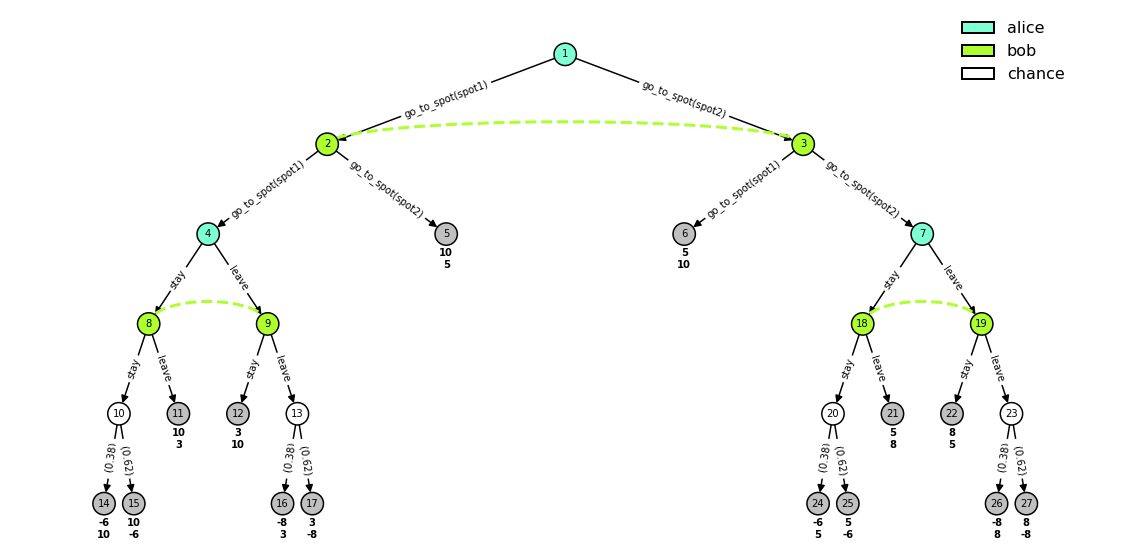

In [7]:
my_fig_kwargs = dict(figsize=(20, 10), frameon=False)
my_node_kwargs = dict(font_size=10, node_size=500, edgecolors='k',
                      linewidths=1.5)
my_edge_kwargs = dict(arrowsize=15, width=1.5)
my_edge_labels_kwargs = dict(font_size=10)
my_patch_kwargs = dict(linewidth=2)
my_legend_kwargs = dict(fontsize=16, loc=(0.85, 0.85), edgecolor='white')
my_info_sets_kwargs = dict(linestyle='--', linewidth=3)
my_utility_label_kwargs = dict(horizontalalignment='center', fontsize=10,
                               weight='bold')

position_colors = {'alice': 'aquamarine', 'bob': 'greenyellow'}

fig = plot_game(game_default,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.08,
                decimals=0,
                info_sets_kwargs=my_info_sets_kwargs)

# fig.savefig("/home/nmontes/OneDrive/Documentos/PhD/ASL-paper/fishers_default.png", dpi=400)

In [8]:
for n, f in game_default.state_fluents.items():
    f.sort()
    print("{} -- {}".format(n, ', '.join(f)))

1 -- at(alice, shore), at(bob, shore)
4 -- at(alice, spot1), at(bob, spot1)
5 -- at(alice, spot1), at(bob, spot2)
6 -- at(alice, spot2), at(bob, spot1)
7 -- at(alice, spot2), at(bob, spot2)
14 -- at(alice, spot1), at(bob, spot1), won_fight(bob)
15 -- at(alice, spot1), at(bob, spot1), won_fight(alice)
11 -- at(alice, spot1), at(bob, spot2)
12 -- at(alice, spot2), at(bob, spot1)
16 -- at(alice, spot2), at(bob, spot2), won_fight(bob)
17 -- at(alice, spot2), at(bob, spot2), won_fight(alice)
24 -- at(alice, spot2), at(bob, spot2), won_fight(bob)
25 -- at(alice, spot2), at(bob, spot2), won_fight(alice)
21 -- at(alice, spot2), at(bob, spot1)
22 -- at(alice, spot1), at(bob, spot2)
26 -- at(alice, spot1), at(bob, spot1), won_fight(bob)
27 -- at(alice, spot1), at(bob, spot1), won_fight(alice)


In [9]:
subgame_mixed_strat, back_utilities, incentives = \
subgame_perfect_equilibrium(game_default, minimize_incentives)

outcome_prob = {t: outcome_probability(game_default, subgame_mixed_strat, t)
                for t in game_default.game_tree.terminal_nodes}
expected_utilities = {p: 0 for p in game_default.players}

for n, p in outcome_prob.items():
    for player in game_default.players:
        expected_utilities[player] += p*game_default.utility[n][player]
    print("{} -- {:.2f}".format(n, p))
    
print(expected_utilities)
print(sum(outcome_prob.values()))

5 -- 0.11
6 -- 0.25
11 -- 0.00
12 -- 0.11
14 -- 0.18
15 -- 0.31
16 -- 0.00
17 -- 0.00
21 -- 0.01
22 -- 0.01
24 -- 0.00
25 -- 0.00
26 -- 0.01
27 -- 0.01
{'alice': 4.805554360942283, 'bob': 4.16907862629295}
1.0


In [10]:
for node, mixed_strategy_profile in subgame_mixed_strat.items():
    print("At node {}: f(s)={:.3f}".format(node, incentives[node]))
    for player, player_strat in mixed_strategy_profile.items():
        print("{}: {}".format(player, player_strat))
    print(back_utilities[node])
    print()

At node 4: f(s)=0.031
alice: {'stay': 0.8228443372613017, 'leave': 0.17715566273869832}
bob: {'stay': 1.0, 'leave': 0.0}
{'alice': 3.8228443372613015, 'bob': 1.7715566273869832}

At node 7: f(s)=0.000
alice: {'stay': 0.41481463302390603, 'leave': 0.5851853669760939}
bob: {'stay': 0.2962969858986209, 'leave': 0.703703014101379}
{'alice': 3.777779019063231, 'bob': 2.14814723919572}

At node 1: f(s)=0.000
alice: {'go_to_spot(spot1)': 0.7086293759741782, 'go_to_spot(spot2)': 0.2913706240258218}
bob: {'go_to_spot(spot1)': 0.840912590479314, 'go_to_spot(spot2)': 0.15908740952068612}
{'alice': 4.805554360942283, 'bob': 4.169078626292952}



In [11]:
violent_outcomes = [14, 15, 16, 17,24, 25, 26, 27]
violent_outcomes_probs = [outcome_prob[t] for t in violent_outcomes]
violence_prob = sum(violent_outcomes_probs)
print(violence_prob)

0.5151145211131013


# *First-in-time, first-in-right* configuration

Now fishers also start from the shore, but if they go to the same fishing spot, the fisher who gets there first is commited to the spot, while the fisher who has lost the race has to leave. The probability that fisher $i$ wins the race if both fishers go to the same spot is:

\begin{equation}
P(\text{$i$ wins race}) = \frac{V_i}{\sum_j V_j}
\end{equation}

where $V_i$ denotes the speed of fisher $i$, a parameter between 1 (slowest) and 10 (fastest).

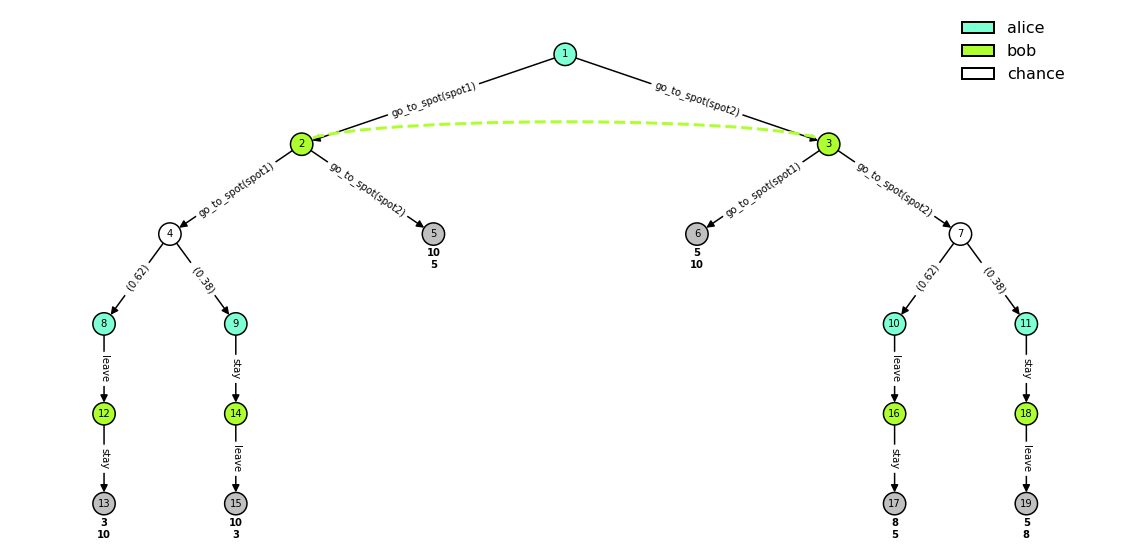

In [12]:
game_race = build_full_game('.', 'fishers', 1)
assign_utilities(game_race)

fig = plot_game(game_race,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.08,
                decimals=0,
                info_sets_kwargs=my_info_sets_kwargs)

# fig.savefig("/home/nmontes/OneDrive/Documentos/PhD/ASL-paper/fishers_race.png", dpi=400)

In [13]:
for n, f in game_race.state_fluents.items():
    f.sort()
    print("{} -- {}".format(n, ', '.join(f)))

1 -- at(alice, shore), at(bob, shore)
8 -- at(alice, spot1), at(bob, spot1), won_race(bob)
9 -- at(alice, spot1), at(bob, spot1), won_race(alice)
5 -- at(alice, spot1), at(bob, spot2)
6 -- at(alice, spot2), at(bob, spot1)
10 -- at(alice, spot2), at(bob, spot2), won_race(bob)
11 -- at(alice, spot2), at(bob, spot2), won_race(alice)
13 -- at(alice, spot2), at(bob, spot1), won_race(bob)
15 -- at(alice, spot1), at(bob, spot2), won_race(alice)
17 -- at(alice, spot1), at(bob, spot2), won_race(bob)
19 -- at(alice, spot2), at(bob, spot1), won_race(alice)


In [14]:
subgame_mixed_strat, back_utilities, incentives = \
    subgame_perfect_equilibrium(game_race, minimize_incentives)

outcome_prob = {t: outcome_probability(game_race, subgame_mixed_strat, t)
                for t in game_race.game_tree.terminal_nodes}
expected_utilities = {p: 0 for p in game_race.players}

for n, p in outcome_prob.items():
    for player in game_race.players:
        expected_utilities[player] += p*game_race.utility[n][player]
    print("{} -- {:.2f}".format(n, p))

print(expected_utilities)

5 -- 0.00
6 -- 0.00
13 -- 0.62
15 -- 0.38
17 -- 0.00
19 -- 0.00
{'alice': 5.6923076923076925, 'bob': 7.307692307692308}


In [15]:
for node, mixed_strategy_profile in subgame_mixed_strat.items():
    print("At node {}: f(s)={:.3f}".format(node, incentives[node]))
    for player, player_strat in mixed_strategy_profile.items():
        print("{}: {}".format(player, player_strat))
    print(back_utilities[node])
    print()

At node 8: f(s)=0.000
alice: {'leave': 1.0}
bob: {'stay': 1.0}
{'alice': 3.0, 'bob': 10.0}

At node 9: f(s)=0.000
alice: {'stay': 1.0}
bob: {'leave': 1.0}
{'alice': 10.0, 'bob': 3.0}

At node 10: f(s)=0.000
alice: {'leave': 1.0}
bob: {'stay': 1.0}
{'alice': 8.0, 'bob': 5.0}

At node 11: f(s)=0.000
alice: {'stay': 1.0}
bob: {'leave': 1.0}
{'alice': 5.0, 'bob': 8.0}

At node 1: f(s)=0.000
alice: {'go_to_spot(spot1)': 1.0, 'go_to_spot(spot2)': 0.0}
bob: {'go_to_spot(spot1)': 1.0, 'go_to_spot(spot2)': 0.0}
{'alice': 5.6923076923076925, 'bob': 7.307692307692308}



# *First-to-announce, first-in-right* configuration

In this configuration, one of the fishers is randomly assigned to the position of announcer. When both fishers are in the shore, anyone can go to any spot before the announcer has declared to one spot. Then, both fishers can go to any of the spots. If the fishers both go the spot that the announcer has declared, the announcer is guaranted to win the race to the spot. If the fishers both go to the spot that has not been declared by the announcer, any of them might win the race to get there. The winner of the race is commited to the spot (she stays) while the looser has to leave.

Note that the rules for this configuration are *in addition* to the *first-in-time, first-in-right* rules, and they have been assigned priority 2 (*first-in-time, first-in-right* rules where assigned priority 1, and the default rules were assigned priority 0, as usual).

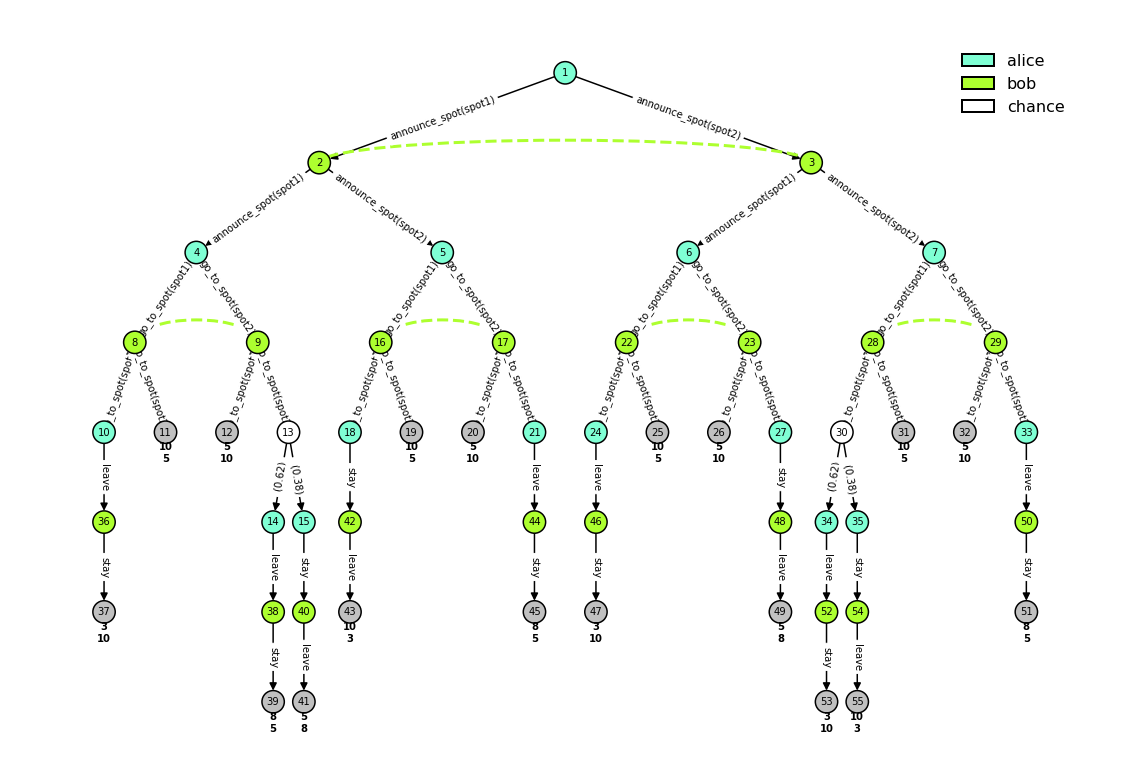

In [16]:
game_announce = build_full_game('.', 'fishers', 2)
assign_utilities(game_announce)

my_fig_kwargs = dict(figsize=(20, 14), frameon=False)
fig = plot_game(game_announce,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.07,
                decimals=0,
                info_sets_kwargs=my_info_sets_kwargs)

# fig.savefig("/home/nmontes/OneDrive/Documentos/PhD/ASL-paper/fishers_announce.png", dpi=400)

In [17]:
for n, f in game_announce.state_fluents.items():
    f.sort()
    print("{} -- {}".format(n, ', '.join(f)))

1 -- at(alice, shore), at(bob, shore)
4 -- announced(alice, spot1), announced(bob, spot1), at(alice, shore), at(bob, shore)
5 -- announced(alice, spot1), announced(bob, spot2), at(alice, shore), at(bob, shore)
6 -- announced(alice, spot2), announced(bob, spot1), at(alice, shore), at(bob, shore)
7 -- announced(alice, spot2), announced(bob, spot2), at(alice, shore), at(bob, shore)
10 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot1), at(bob, spot1), won_race(bob)
11 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot1), at(bob, spot2)
12 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot2), at(bob, spot1)
14 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot2), at(bob, spot2), won_race(bob)
15 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot2), at(bob, spot2), won_race(alice)
18 -- announced(alice, spot1), announced(bob, spot2), at(alice, spot1), at(bob, spot1), won_race(alice)
19 -- announced(alice, spot1), a

In [18]:
subgame_mixed_strat, back_utilities, incentives = \
    subgame_perfect_equilibrium(game_announce, minimize_incentives)

outcome_prob = {t: outcome_probability(game_announce, subgame_mixed_strat, t)
                for t in game_announce.game_tree.terminal_nodes}
expected_utilities = {p: 0 for p in game_announce.players}

for n, p in outcome_prob.items():
    for player in game_announce.players:
        expected_utilities[player] += p*game_announce.utility[n][player]
    print("{} -- {:.2f}".format(n, p))

print(expected_utilities)

11 -- 0.00
12 -- 0.60
19 -- 0.00
20 -- 0.00
25 -- 0.00
26 -- 0.40
31 -- 0.00
32 -- 0.00
37 -- 0.00
39 -- 0.00
41 -- 0.00
43 -- 0.00
45 -- 0.00
47 -- 0.00
49 -- 0.00
51 -- 0.00
53 -- 0.00
55 -- 0.00
{'alice': 5.000000000000053, 'bob': 9.999999999999465}


In [19]:
for node, mixed_strategy_profile in subgame_mixed_strat.items():
    print("At node {}: f(s)={:.3f}".format(node, incentives[node]))
    for player, player_strat in mixed_strategy_profile.items():
        print("{}: {}".format(player, player_strat))
    print(back_utilities[node])
    print()

At node 10: f(s)=0.000
alice: {'leave': 1.0}
bob: {'stay': 1.0}
{'alice': 3.0, 'bob': 10.0}

At node 14: f(s)=0.000
alice: {'leave': 1.0}
bob: {'stay': 1.0}
{'alice': 8.0, 'bob': 5.0}

At node 15: f(s)=0.000
alice: {'stay': 1.0}
bob: {'leave': 1.0}
{'alice': 5.0, 'bob': 8.0}

At node 18: f(s)=0.000
alice: {'stay': 1.0}
bob: {'leave': 1.0}
{'alice': 10.0, 'bob': 3.0}

At node 21: f(s)=0.000
alice: {'leave': 1.0}
bob: {'stay': 1.0}
{'alice': 8.0, 'bob': 5.0}

At node 24: f(s)=0.000
alice: {'leave': 1.0}
bob: {'stay': 1.0}
{'alice': 3.0, 'bob': 10.0}

At node 27: f(s)=0.000
alice: {'stay': 1.0}
bob: {'leave': 1.0}
{'alice': 5.0, 'bob': 8.0}

At node 33: f(s)=0.000
alice: {'leave': 1.0}
bob: {'stay': 1.0}
{'alice': 8.0, 'bob': 5.0}

At node 34: f(s)=0.000
alice: {'leave': 1.0}
bob: {'stay': 1.0}
{'alice': 3.0, 'bob': 10.0}

At node 35: f(s)=0.000
alice: {'stay': 1.0}
bob: {'leave': 1.0}
{'alice': 10.0, 'bob': 3.0}

At node 4: f(s)=0.000
alice: {'go_to_spot(spot1)': 4.440892098500626e-15, '